# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import bottleneck as bn

In [180]:
df=pd.read_csv("https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv",encoding="utf-8")

In [181]:
df.head()

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


In [182]:
df.describe()

,part,company,country,city,price,date
count,20558,20568,18397,20535,20567,20568
unique,100,35,13,30,19214,20552
top,17156-617,Thoughtmix,Portugal,Amadora\t,-,10/04/2017
freq,300,2795,7383,2787,5,7


In [183]:
df.dtypes

part       object
company    object
country    object
city       object
price      object
date       object
dtype: object

In [184]:
for column in df.columns:
    print("Data type in {} is {}.".format(column,type(df[column][0])))

Data type in part is <class 'str'>.
Data type in company is <class 'str'>.
Data type in country is <class 'str'>.
Data type in city is <class 'str'>.
Data type in price is <class 'str'>.
Data type in date is <class 'str'>.


In [185]:
# check for empty string
for column in df.columns:
    print("" in df[column])

False
False
False
False
False
False


In [186]:
# check for NaN
for column in df.columns:
    print("column {} has {} null value".format(column, df[column].isnull().sum().sum()))

column part has 10 null value
column company has 0 null value
column country has 2171 null value
column city has 33 null value
column price has 1 null value
column date has 0 null value


### part column

In [187]:
df.part.nunique()

100

In [188]:
df.part.value_counts(dropna = False).head()

17156-617     300
37205-992     295
0268-6107     293
52959-433     293
54868-0823    292
Name: part, dtype: int64

#### handle missing values in `part`

In [189]:
df[df.part.isnull()]

,part,company,country,city,price,date
14916,NaN,Yozio,Greece,Patras,518.38€,2018-02-17 21:43:43
14917,NaN,Brainsphere,Portugal,Braga,957.24€,2018-02-17 22:12:24
14918,NaN,Lajo,Greece,Thessaloniki,966.06€,2018-02-17 22:54:49
14919,NaN,Roodel,Portugal,Aranhas,873.65€,2018-02-17 23:36:52
17524,NaN,Yozio,Greece,Patras,627.32€,2018-07-12 03:28:46
17525,NaN,Thoughtmix,Portugal,Amadora\t,825.8€,2018-07-12 05:34:07
17526,NaN,Gabcube,Portugal,Almada,188.31€,2018-07-12 06:49:44
17527,NaN,Buzzbean,Germany,Düsseldorf,429.67€,2018-07-12 07:03:50
17528,NaN,Zoonder,United States,Boston,$521.72,2018-07-12 08:38:56
17529,NaN,Twitterbeat,France,Annecy,1031.46€,2018-07-12 09:48:17


In [190]:
prop_nan_part = len(df[df.part.isnull()])/len(df)
prop_nan_part

0.0004861921431349669

Since the proportion of missing values in the part column is only 0.049% of the entire dataset, we can remove the rows with missing part entries.

In [191]:
df=df.dropna(subset=['part'])

In [192]:
df[df.part.isnull()]

,part,company,country,city,price,date


### company column

#### clean strings in `company`

In [193]:
df.company.unique()

array(['Chatterbridge', 'Lajo', 'Flipstorm', 'Twitterbeat', 'Voomm',
       'Buzzbean', 'Zooxo', 'Brainsphere', 'Thoughtmix', 'Wordify',
       'Teklist', 'Avaveo', 'Ntags', 'Innojam', 'Shufflebeat', 'Zoonder',
       'Kanoodle', 'Gabcube', 'Roodel', 'Riffpath', 'Eimbee', 'Yozio',
       'Rhycero', 'Realpoint', 'Gabtune', 'Bubblemix', 'Gevee', 'Tagtune',
       'Zooxo.', 'Laj0', 'Ntagz', ' -', ' a', 'aa', 'Thoughtmixz'],
      dtype=object)

In [194]:
df.company.value_counts(dropna=False)

Thoughtmix       2794
Twitterbeat      2267
Zooxo            1670
Chatterbridge    1589
Shufflebeat      1553
Ntags            1514
Buzzbean         1253
Brainsphere      1241
Flipstorm        1193
Wordify           968
Yozio             653
Roodel            626
Eimbee            498
Zoonder           453
Teklist           428
Gabcube           356
Voomm             250
Lajo              219
Avaveo            212
Rhycero           204
Realpoint         158
Riffpath          151
Kanoodle          127
Bubblemix          54
Innojam            44
Gevee              36
Gabtune            27
Tagtune            12
Zooxo.              2
Thoughtmixz         1
 a                  1
 -                  1
Ntagz               1
aa                  1
Laj0                1
Name: company, dtype: int64

From the above result, it can be seen that some erroneous company names/poorly formatted company names. These include:
* ` a`,`aa`,` -` each has occurred once in the dataset. They are likely to be the erroneous entries. Simply remove them.
* `Laj0` should be standardized to `Lajo`. Likewise, `Zooxo.` should be standardized to `Zooxo`; `Thoughtmixz` should be standardized to `Thoughtmix`; `Ntagz` should be standardized to `Ntags`

In [195]:
df.company = df.company.replace([' a','aa',' -'], '')
df=df[df.company != '']

In [196]:
df.company = df.company.replace('Zooxo.','Zooxo')
df.company = df.company.replace('Laj0','Lajo')
df.company = df.company.replace('Thoughtmixz','Thoughtmix')
df.company = df.company.replace('Ntagz','Ntags')

In [197]:
df.company.value_counts(dropna=False)

Thoughtmix       2795
Twitterbeat      2267
Zooxo            1672
Chatterbridge    1589
Shufflebeat      1553
Ntags            1515
Buzzbean         1253
Brainsphere      1241
Flipstorm        1193
Wordify           968
Yozio             653
Roodel            626
Eimbee            498
Zoonder           453
Teklist           428
Gabcube           356
Voomm             250
Lajo              220
Avaveo            212
Rhycero           204
Realpoint         158
Riffpath          151
Kanoodle          127
Bubblemix          54
Innojam            44
Gevee              36
Gabtune            27
Tagtune            12
Name: company, dtype: int64

In [198]:
df[df['company'].isnull()]

,part,company,country,city,price,date


### country column

#### clean strings in `country`

In [199]:
df.country.unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland',
       nan, 'US', 'Tyskland', 'Portuga'], dtype=object)

From the `unique()` result, we can see that `United States` and `US` are the same and thus should be standardized. 
<br>
Similarly, `Portugal` and `Portuga` should be standardized. 
<br>
Additionally, `Tyskland` means `Germany` in Swedish. Thus they need to be standardized too.

In [200]:
df.country = df.country.replace('US', 'United States')
df.country = df.country.replace('Portuga', 'Portugal')
df.country = df.country.replace('Tyskland', 'Germany')

In [201]:
df.country.unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland',
       nan], dtype=object)

#### handle missing values in  `country` 

In [202]:
df[df.country.isnull()].head()

,part,company,country,city,price,date
2528,52380-1102,Teklist,NaN,Arnhem,357.78,2016-04-21 04:07:31
2947,52125-136,Brainsphere,NaN,Braga,493.94€,2016-05-10 11:13:43
2956,16714-295,Teklist,NaN,Arnhem,624.4€,2016-05-10 21:57:15
2994,76335-006,Buzzbean,NaN,Düsseldorf,355.24€,2016-05-12 15:17:37
3948,54473-578,Brainsphere,NaN,Braga,123.32€,2016-07-01 01:09:40


In [203]:
len(df[df.country.isnull()])

2171

In [204]:
prop_nan_country = len(df[df.country.isnull()])/len(df)
prop_nan_country

0.1056190707856969

Since the fraction of missing values in the country column is 10.43% of the entire dataset which is considerably large, we cannot simply remove the rows with missing countries entries as doing so will result in much information being lost.
<br>
<br>
Instead, we can deduce some of the country names from their corresponding cities.

In [205]:
df.groupby(['city'])['country'].value_counts(dropna = False).head()

city       country 
Almada     Portugal     323
           NaN           33
Amadora\t  Portugal    2511
           NaN          275
Amiens     France       452
Name: country, dtype: int64

In [206]:
city_country_mapping = df.groupby(['city'])['country'].apply(lambda grp: list(grp.value_counts().index)[0]).to_dict()
city_country_mapping

{'Almada': 'Portugal',
 'Amadora\t': 'Portugal',
 'Amiens': 'France',
 'Amsterdam': 'Netherlands',
 'Annecy': 'France',
 'Aranhas': 'Portugal',
 'Arcueil': 'France',
 'Arnhem': 'Netherlands',
 'Asaka': 'Japan',
 'Athens': 'Greece',
 'Barcelona': 'Spain',
 'Boston': 'United States',
 'Braga': 'Portugal',
 'Champagnole': 'France',
 'Düsseldorf': 'Germany',
 'Heraklion': 'Greece',
 'Lisbon': 'Portugal',
 'London': 'United Kingdom',
 'Lyon': 'France',
 'Monção': 'Portugal',
 'Nanterre': 'France',
 'New York': 'United States',
 'Nice': 'France',
 'Niihama': 'Japan',
 'Paris': 'France',
 'Patras': 'Greece',
 'Porto': 'Portugal',
 'Thessaloniki': 'Greece',
 'Vila Fria': 'Portugal',
 'Zürich': 'Switzerland'}

In [207]:
df[df.country.isnull()].index

Int64Index([ 2528,  2947,  2956,  2994,  3948,  3949,  3950,  3951,  3952,
             3953,
            ...
            12843, 12978, 13721, 14438, 16146, 16147, 16148, 16149, 16150,
            16151],
           dtype='int64', length=2171)

In [208]:
def impute_countries(row):
    try:
        res=city_country_mapping[row.city]
    except KeyError:
        res=float('NaN')
    return res

In [209]:
df.country = df.apply(impute_countries, axis = 1)

In [210]:
len(df[df.country.isna()])

33

In [211]:
df[df.country.isna()]

,part,company,country,city,price,date
3136,68462-565,Brainsphere,NaN,NaN,1057.85€,2016-05-20 08:59:53
3137,54092-515,Shufflebeat,NaN,NaN,772.92€,2016-05-20 09:55:24
3138,0185-0373,Brainsphere,NaN,NaN,1012.8€,2016-05-20 10:42:10
12820,50563-113,Ntags,NaN,NaN,507.49€,2017-10-20 04:03:11
12821,55154-5057,Brainsphere,NaN,NaN,421.64€,2017-10-20 13:23:34
12822,36987-1697,Ntags,NaN,NaN,937.08€,2017-10-20 18:25:00
12823,68462-565,Thoughtmix,NaN,NaN,777.58€,2017-10-20 21:21:18
12824,0603-6134,Yozio,NaN,NaN,775.05€,2017-10-20 23:17:59
12825,58118-5060,Yozio,NaN,NaN,157.53€,2017-10-20 23:49:53
12826,51060-032,Thoughtmix,NaN,NaN,176.36€,2017-10-21 00:11:55


### city column

#### clean strings in `city`

In [212]:
df.city.unique()

array(['Barcelona', 'Thessaloniki', 'Athens', 'Annecy', 'Paris',
       'Düsseldorf', 'London', 'Braga', 'Nanterre', 'Amadora\t',
       'New York', 'Arnhem', 'Nice', 'Lisbon', 'Amsterdam', 'Porto',
       'Boston', 'Niihama', 'Almada', 'Aranhas', 'Heraklion', 'Amiens',
       'Patras', 'Arcueil', 'Lyon', 'Asaka', 'Champagnole', 'Zürich', nan,
       'Monção', 'Vila Fria'], dtype=object)

Result from `unique()` shows that there is an additional `\t` in the city `Amadora`. Remove the`\t`s:

In [213]:
df.city = df.city.str.replace("\t","")

In [214]:
df.city.unique()

array(['Barcelona', 'Thessaloniki', 'Athens', 'Annecy', 'Paris',
       'Düsseldorf', 'London', 'Braga', 'Nanterre', 'Amadora', 'New York',
       'Arnhem', 'Nice', 'Lisbon', 'Amsterdam', 'Porto', 'Boston',
       'Niihama', 'Almada', 'Aranhas', 'Heraklion', 'Amiens', 'Patras',
       'Arcueil', 'Lyon', 'Asaka', 'Champagnole', 'Zürich', nan, 'Monção',
       'Vila Fria'], dtype=object)

#### handle missing values in `city`

In [215]:
df[df.city.isnull()]

,part,company,country,city,price,date
3136,68462-565,Brainsphere,NaN,NaN,1057.85€,2016-05-20 08:59:53
3137,54092-515,Shufflebeat,NaN,NaN,772.92€,2016-05-20 09:55:24
3138,0185-0373,Brainsphere,NaN,NaN,1012.8€,2016-05-20 10:42:10
12820,50563-113,Ntags,NaN,NaN,507.49€,2017-10-20 04:03:11
12821,55154-5057,Brainsphere,NaN,NaN,421.64€,2017-10-20 13:23:34
12822,36987-1697,Ntags,NaN,NaN,937.08€,2017-10-20 18:25:00
12823,68462-565,Thoughtmix,NaN,NaN,777.58€,2017-10-20 21:21:18
12824,0603-6134,Yozio,NaN,NaN,775.05€,2017-10-20 23:17:59
12825,58118-5060,Yozio,NaN,NaN,157.53€,2017-10-20 23:49:53
12826,51060-032,Thoughtmix,NaN,NaN,176.36€,2017-10-21 00:11:55


In [216]:
len(df[df.city.isnull()])

33

In [217]:
df.groupby(["company","country",'city']).count()

part  price  date
company       country        city                           
Avaveo        France         Nice           212    212   212
Brainsphere   Portugal       Braga         1236   1236  1236
                             Monção           1      1     1
Bubblemix     Japan          Asaka           54     54    54
Buzzbean      Germany        Düsseldorf    1253   1253  1253
Chatterbridge Spain          Barcelona     1589   1589  1589
Eimbee        France         Amiens         498    498   498
Flipstorm     France         Nanterre       381    381   381
              Greece         Athens         812    812   812
Gabcube       Portugal       Almada         356    356   356
Gabtune       France         Lyon            27     27    27
Gevee         France         Champagnole     36     36    36
Innojam       Netherlands    Amsterdam       44     44    44
Kanoodle      Japan          Niihama        126    126   126
Lajo          Greece         Thessaloniki   220    220   220
Ntags         Portugal       Lisbon        1509   1509  1509
Realpoint     Portugal       Lisbon         158    158   158
Rhycero       France         Arcueil        204    204   204
Riffpath      Greece         Heraklion      151    151   151
Roodel        Portugal       Aranhas        626    625   626
Shufflebeat   Portugal       Porto         1550   1550  1550
Tagtune       Switzerland    Zürich          12     12    12
Teklist       Netherlands    Arnhem         426    426   426
Thoughtmix    Portugal       Amadora       2786   2786  2786
                             Vila Fria        1      1     1
Twitterbeat   France         Annecy        2266   2266  2266
Voomm         France         Paris          250    250   250
Wordify       United States  New York       966    966   966
Yozio         Greece         Patras         651    651   651
Zoonder       United States  Boston         452    452   452
Zooxo         United Kingdom London        1669   1669  1669

In [218]:
prop_nan_city = len(df[df.city.isnull()])/len(df)
prop_nan_city

0.001605448795913403

Since the proportion of missing values in the city column is only 0.16% of the entire dataset, we can remove the rows with missing city entries.
<br>
<br>
Moreover, the table above shows that all but three records have missing values in both country and city. This implies that dropping records that have missing values in the city column does not cause a big loss in information in the country column, since only three such country records are not null.

In [219]:
df=df.dropna(subset=['city'])

In [220]:
df[df.city.isnull()]

,part,company,country,city,price,date


### date column

In [221]:
# string to datetime object
df['parsed_date'] = pd.to_datetime(df['date'],errors='coerce', infer_datetime_format=True)

In [222]:
# checking
df[df.parsed_date.isnull()]

,part,company,country,city,price,date,parsed_date
3539,17156-617,Thoughtmix,Portugal,Amadora,791.86€,2016-06-32 07:22:28,NaT
3540,54868-5165,Shufflebeat,Portugal,Porto,525.24€,2016-06-32 08:08:48,NaT


In [223]:
df = df.dropna()

### price column

In [224]:
# original intention was to find all currency signs present
# but it turned out that there are other poorly formatted cells other than currency signs
res=[]
for p in df.price:
    for c in p:
        if c.isdigit() == False:
            res.append(c)
x=np.array(res)
np.unique(x)

array(['$', '-', '.', 'a', 'd', 'i', 'n', 'o', 'v', '£', '¥', '€'],
      dtype='<U1')

In [225]:
# find what are those cells
res=[]
for p in df.price:
    for c in p:
        if c in ['a', 'd', 'i', 'n', 'o', 'v']:
            print(p)
            break

void
void
na
na
na


In [226]:
print(len(df))
df=df[df.price != 'void']
df=df[df.price != 'na']
print(len(df))

20519
20514


In [227]:
def parse_price(string):
    amount=re.match(r'([^-\d\.]?)(-?\d*\.?\d*)([\D]?)', str(string))
    lst=[i for i in amount.groups() if i != '']
#     if len(lst) != 2:
#         return float('NaN')
    try:
        res=float(lst[0])
    except ValueError:
        res=float(lst[1])
    return res

In [228]:
def parse_symbol(string):
    amount=re.match(r'([^-\d\.]?)(-?\d*\.?\d*)([\D]?)', str(string))
    lst=[i for i in amount.groups() if i != '']
#     if len(lst) != 2:
#         return float('NaN')
    try:
        number=float(lst[0])
        sign=lst[1]
    except ValueError:
        sign=lst[0]
    return sign

In [229]:
def find_currency(string):
    currency=re.findall("[€$¥£]",string)
    if currency:
        symbol=currency[0]
        if symbol == "€":
            return "EUR"
        elif symbol == "$":
            return "USD"
        elif symbol == "¥":
            return "CNY"
        elif symbol == "£":
            return "GBP"
    else:
        print("error: can't find currenct symbol in {}".format(string))

In [230]:
df["currency"]=df.price.apply(find_currency)

error: can't find currenct symbol in 465.6
error: can't find currenct symbol in 1266.68
error: can't find currenct symbol in 829.3
error: can't find currenct symbol in 357.78
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -
error: can't find currenct symbol in -


In [231]:
df=df[df['price'] != "465.6"]
df=df[df['price'] != "1266.68"]
df=df[df['price'] != "829.3"]
df=df[df['price'] != "357.78"]
df=df[df['price'] != "-"]

In [232]:
df['price_amount']=df.price.apply(parse_price)

In [233]:
df['price_symbol']=df.price.apply(parse_symbol)

In [234]:
df.tail()

,part,company,country,city,price,date,parsed_date,currency,price_amount,price_symbol
20563,21695-267,Roodel,Portugal,Aranhas,606.37€,2018-12-31 20:48:14,2018-12-31 20:48:14,EUR,606.37,€
20564,49999-737,Thoughtmix,Portugal,Amadora,828.37€,2018-12-31 21:24:17,2018-12-31 21:24:17,EUR,828.37,€
20565,52343-025,Brainsphere,Portugal,Braga,686.1€,2018-12-31 21:38:02,2018-12-31 21:38:02,EUR,686.10,€
20566,49288-0285,Flipstorm,Greece,Athens,1051.08€,2019-02-21 20:05:00,2019-02-21 20:05:00,EUR,1051.08,€
20567,43419-018,Flipstorm,Greece,Athens,139.56€,2019-05-14 22:48:39,2019-05-14 22:48:39,EUR,139.56,€


In [235]:
df.isnull().sum().sum()

0

In [236]:
df=df.drop(columns='date')
df.rename(columns={"parsed_date" : "date", 
                   "currency": "currency_name",
                   "price_symbol":"currency_symbol"}, inplace=True)

In [237]:
df.head()

,part,company,country,city,price,date,currency_name,price_amount,currency_symbol
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€


---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

In [238]:
import datetime
from forex_python.converter import CurrencyRates

#### External Data 1 --> Exchange Rate
<describe why use this particular external data, how it can enhance the existing dataset, etc.>

In [239]:
c = CurrencyRates()

In [240]:
def ToUSD(currency,date):
    return c.convert(currency, 'USD', 1 , date)

In [241]:
USD=[]
dic={}
for i in range(len(df)):
    if i == 2000:
        print("I'm 10% done!")
    if i == 5000:
        print("Hang on, Ms.Pretty/Mr.Handsome. I'm doing my best!")
    if i == 10000:
        print("Yeah, I'm 50% done!")
    if i == 15000:
        print("Waiting is boring, why not sing a song? La la la ~")
    if i == 20000:
        print("Almost there, give me 10s!")
    date=df.iloc[i,5].date()
    currency=df.iloc[i,6]
    key=(currency,date)
    if key in dic:
        USD.append(dic[key])
    else:
        dic[key] = ToUSD(currency,date)
        USD.append(dic[key])
print("YAS! I'm done!")

I'm 10% done!
Hang on, Ms.Pretty/Mr.Handsome. I'm doing my best!
Yeah, I'm 50% done!
Waiting is boring, why not sing a song? La la la ~
Almost there, give me 10s!
YAS! I'm done!


In [242]:
df['exchange_rate_to_USD'] = USD

In [243]:
df['standardized_USD'] = df.price_amount * df.exchange_rate_to_USD

In [244]:
df.tail()

,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD
20563,21695-267,Roodel,Portugal,Aranhas,606.37€,2018-12-31 20:48:14,EUR,606.37,€,1.1450,694.293650
20564,49999-737,Thoughtmix,Portugal,Amadora,828.37€,2018-12-31 21:24:17,EUR,828.37,€,1.1450,948.483650
20565,52343-025,Brainsphere,Portugal,Braga,686.1€,2018-12-31 21:38:02,EUR,686.10,€,1.1450,785.584500
20566,49288-0285,Flipstorm,Greece,Athens,1051.08€,2019-02-21 20:05:00,EUR,1051.08,€,1.1354,1193.396232
20567,43419-018,Flipstorm,Greece,Athens,139.56€,2019-05-14 22:48:39,EUR,139.56,€,1.1226,156.670056


save the above dataframe as a pickle object for easy access:

In [245]:
with open(r"df.pickle", "wb") as output_file:
    pickle.dump(df, output_file)

#### External Data 2 --> GDP
<describe why use this particular external data, how it can enhance the existing dataset, etc.>

In [26]:
GDP=pd.read_csv("https://raw.githubusercontent.com/YangYuesong0323/Computational_Tools/master/GDP.csv")

In [27]:
GDP=GDP.drop(columns=['Country Code','Indicator Name','Indicator Code'])

GDP=GDP.rename(columns={'Country Name':'country'})

GDP_long=pd.melt(GDP,id_vars=['country'], var_name='year', value_name='value')

In [28]:
GDP_long.head()

,country,year,value
0,Aruba,1960,NaN
1,Afghanistan,1960,537777811.1
2,Angola,1960,NaN
3,Albania,1960,NaN
4,Andorra,1960,NaN


#### External Data 3 --> Population
<describe why use this particular external data, how it can enhance the existing dataset, etc.>

In [29]:
Population=pd.read_csv("https://raw.githubusercontent.com/YangYuesong0323/Computational_Tools/master/population.csv")

In [30]:
Population=Population.drop(columns=['Country Code','Indicator Name','Indicator Code'])

Population=Population.rename(columns={'Country Name':'country'})

Population_long=pd.melt(Population,id_vars=['country'], var_name='year', value_name='value')

In [31]:
Population_long.head()

,country,year,value
0,Aruba,1960,54211.0
1,Afghanistan,1960,8996973.0
2,Angola,1960,5454933.0
3,Albania,1960,1608800.0
4,Andorra,1960,13411.0


---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

#### create a database named `project1`

In [32]:
import sqlite3

In [33]:
conn = sqlite3.connect('project1.sqlite')
c = conn.cursor()

#### create a table named `customer` from the pandas dataframe `df`

Since the current dataframe `df` does not have a primary key, we create another column called `key` and fill this column with the index of each row, i.e. use the row index as the primary key 

In [34]:
with open(r"df.pickle", "rb") as output_file:
    df = pickle.load(output_file)

In [35]:
df.insert(0, 'key', range(len(df)))

In [36]:
df.head()

,key,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD
0,0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€,1.0887,854.400873
1,1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€,1.0887,204.664713
2,2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€,1.0887,241.397451
3,3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€,1.0887,1171.245234
4,4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€,1.0887,449.143185


In [37]:
df['year'] = df.date.apply(lambda x : x.year)
df['month'] = df.date.apply(lambda x : x.month)

In [38]:
df.head()

,key,part,company,country,city,price,date,currency_name,price_amount,currency_symbol,exchange_rate_to_USD,standardized_USD,year,month
0,0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,€,1.0887,854.400873,2016,1
1,1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,€,1.0887,204.664713,2016,1
2,2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,€,1.0887,241.397451,2016,1
3,3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,€,1.0887,1171.245234,2016,1
4,4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,€,1.0887,449.143185,2016,1


In [39]:
df.columns

Index(['key', 'part', 'company', 'country', 'city', 'price', 'date',
       'currency_name', 'price_amount', 'currency_symbol',
       'exchange_rate_to_USD', 'standardized_USD', 'year', 'month'],
      dtype='object')

In [40]:
c.execute('''DROP TABLE IF EXISTS customer;''')
conn.commit()

In [41]:
c.execute('''CREATE TABLE IF NOT EXISTS customer(
key INTEGER PRIMARY KEY, 
part varchar(20), 
company varchar(20), 
country varchar(30), 
city varchar(20), 
price varchar(10), 
date DATETIME, 
currency_name varchar(3), 
price_amount float(10), 
currency_symbol varchar(1), 
exchange_rate_to_USD float(10), 
standardized_USD float(10),
year DATETIME,
month DATETIME,
FOREIGN KEY (company, year) REFERENCES gdp(company, year))''')
conn.commit()

In [42]:
df.to_sql('customer', conn, if_exists='replace', index=False)
conn.commit()

In [43]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT Count(*) FROM customer')
print('number of rows in the sqlite customer table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas df dataframe is {}'.format(len(df)))
conn.commit()

number of rows in the sqlite customer table is 20505
number of rows in the pandas df dataframe is 20505


In [44]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT * FROM customer')
print('first row in the sqlite customer table is {}'.format(c.fetchone()))
print()
print('first row in the pandas df dataframe is {}'.format(tuple(df.iloc[0])))
conn.commit()

first row in the sqlite customer table is (0, '54868-5165', 'Chatterbridge', 'Spain', 'Barcelona', '784.79€', '2016-01-02 00:01:05', 'EUR', 784.79, '€', 1.0887, 854.4008729999999, 2016, 1)

first row in the pandas df dataframe is (0, '54868-5165', 'Chatterbridge', 'Spain', 'Barcelona', '784.79€', Timestamp('2016-01-02 00:01:05'), 'EUR', 784.79, '€', 1.0887, 854.4008729999999, 2016, 1)


#### create a table named `gdp` from the pandas dataframe `GDP_long`

In [45]:
GDP_long.columns

Index(['country', 'year', 'value'], dtype='object')

In [46]:
c.execute('''DROP TABLE IF EXISTS gdp;''')
conn.commit()

None of the attributes can uniquely identify the row entries. However, we can uniquely identify a row by using `country` and `year` combined. Therefore, we set `country` and `year` as the composite key to the table. 

In [47]:
c.execute('''CREATE TABLE IF NOT EXISTS gdp( 
country varchar(64), 
year varchar(10), 
value float(10),
PRIMARY KEY (country, year))''')
conn.commit()

In [48]:
GDP_long.to_sql('gdp', conn, if_exists='replace', index=False)
conn.commit()

In [49]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT Count(*) FROM gdp')
print('number of rows in the sqlite gdp table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas GDP_long dataframe is {}'.format(len(GDP_long)))
conn.commit()


number of rows in the sqlite gdp table is 15576
number of rows in the pandas GDP_long dataframe is 15576


In [50]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT * FROM gdp')
print('first row in the sqlite gdp table is {}'.format(c.fetchone()))
print()
print('first row in the pandas GDP_long dataframe is {}'.format(tuple(GDP_long.iloc[0])))
conn.commit()

first row in the sqlite gdp table is ('Aruba', '1960', None)

first row in the pandas GDP_long dataframe is ('Aruba', '1960', nan)


#### create a table named `population` from the pandas dataframe `Population_long`

In [51]:
Population_long.columns

Index(['country', 'year', 'value'], dtype='object')

In [52]:
c.execute('''DROP TABLE IF EXISTS population;''')
conn.commit()

None of the attributes can uniquely identify the row entries. However, we can uniquely identify a row by using `country` and `year` combined. Therefore, we set `country` and `year` as the composite key to the table. 

In [53]:
c.execute('''CREATE TABLE IF NOT EXISTS population(
country varchar(64), 
year varchar(10), 
value float(10),
PRIMARY KEY (country, year))''')
conn.commit()

In [54]:
Population_long.to_sql('population', conn, if_exists='replace', index=False)
conn.commit()

In [55]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT Count(*) FROM population')
print('number of rows in the sqlite population table is {}'.format(c.fetchone()[0]))
print('number of rows in the pandas Population_long dataframe is {}'.format(len(Population_long)))
conn.commit()


number of rows in the sqlite population table is 15576
number of rows in the pandas Population_long dataframe is 15576


In [56]:
# code to test whether the sqlite table created is the same as the original pandas dataframe

c.execute('SELECT * FROM population')
print('first row in the sqlite population table is {}'.format(c.fetchone()))
print()
print('first row in the pandas Population_long dataframe is {}'.format(tuple(Population_long.iloc[0])))
conn.commit()

first row in the sqlite population table is ('Aruba', '1960', 54211.0)

first row in the pandas Population_long dataframe is ('Aruba', '1960', 54211.0)


---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

#### Q1: Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

To answer this question, we have defined a function `topN` to display the top N companies with the highest total profits, both in tabular and in graphical forms.

In [57]:
# helper function to decompose the topN_list obtained from the sql query
def decomposeList(index, lst):
    return [x[index] for x in lst]

In [58]:
def TopN(num):
        
    # SQL query to select the top N most profitable companies in terms of their profit totals
    c.execute('''
    SELECT company, sum(standardized_USD) as ProfitSum
    FROM customer
    Group By company
    Order By ProfitSum DESC
    Limit {}
    '''.format(num))
    
    topN_list=c.fetchall()
    
    # consolidate the result into a pandas dataframe
    topN_df = pd.DataFrame(topN_list, columns=['company', 'total profits'])
    print("The top {} most profitable clients are:".format(num))
    print()
    print(topN_df)    
    
    # use a bar plot to visualize the total profits of the top N clients in descending order
    plt.figure(figsize=(12,5))
    plt.bar(x=decomposeList(0,topN_list), height=decomposeList(1,topN_list))
    plt.title("Top {} Clients With The Largest Total Profits".format(num))
    plt.xlabel("Client Name")
    plt.xticks(rotation=45, ha="right") # rotate the x labels by 45 degrees to avoid cluttering of the texts
    plt.ylabel("Total Profit")  
    plt.show()

The top 5 most profitable clients are:

       company  total profits
0   Thoughtmix   1.845760e+06
1  Twitterbeat   1.508610e+06
2     Kanoodle   1.347284e+06
3        Zooxo   1.132010e+06
4  Shufflebeat   1.047283e+06


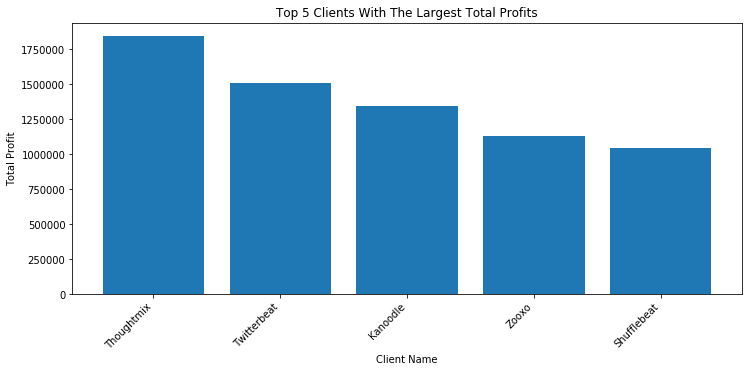

In [59]:
# for example, show the top 5 clients with the largest total profits
TopN(5)

The top 20 most profitable clients are:

          company  total profits
0      Thoughtmix   1.845760e+06
1     Twitterbeat   1.508610e+06
2        Kanoodle   1.347284e+06
3           Zooxo   1.132010e+06
4     Shufflebeat   1.047283e+06
5   Chatterbridge   1.046740e+06
6           Ntags   9.579389e+05
7     Brainsphere   8.162344e+05
8        Buzzbean   8.124586e+05
9       Flipstorm   7.466638e+05
10        Wordify   6.051572e+05
11      Bubblemix   5.113273e+05
12          Yozio   4.169176e+05
13         Roodel   4.121051e+05
14         Eimbee   3.361625e+05
15        Zoonder   2.963728e+05
16        Teklist   2.735835e+05
17        Gabcube   2.325866e+05
18          Voomm   1.608792e+05
19         Avaveo   1.441151e+05


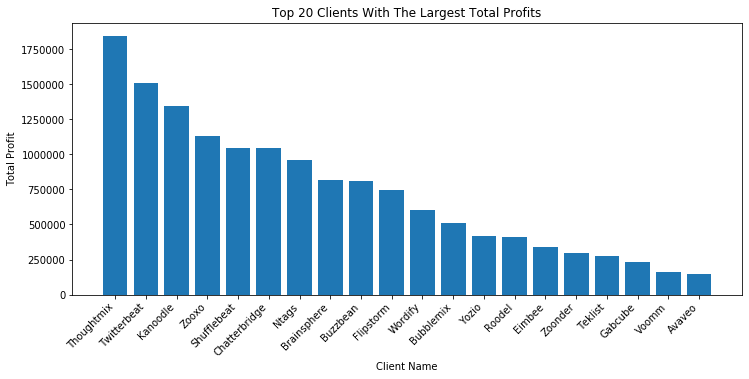

In [60]:
# test again, but this time round use N=20
TopN(20)

#### Q2 Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.

### Year

In [268]:
c.execute('''
SELECT company, SUM(standardized_USD), year
FROM customer
GROUP BY company, year
''')
yearlyAggre=c.fetchall()

In [261]:
def get_one_plot(name):
    def getYearlyAggre(name):
        value=[x[1] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]
        year=[x[2] for x in list(filter(lambda x : x[0] == name, yearlyAggre))]
        return (value, year)
    plt.bar(x=getYearlyAggre(name)[1],height=getYearlyAggre(name)[0])
    plt.xticks(getYearlyAggre(name)[1],getYearlyAggre(name)[1])
    plt.title(name)
    plt.xlabel("year")
    plt.ylabel("Total Profit in USD")
    plt.show()

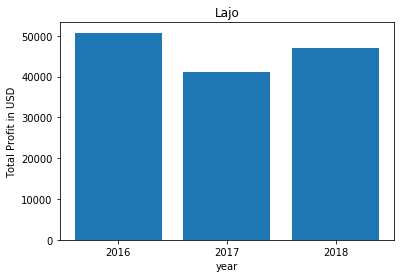

In [285]:
get_one_plot('Lajo')

### Month

In [250]:
# fetch data from the database for further queries
c.execute('''
SELECT company, year, month, SUM(standardized_USD)
FROM customer
GROUP BY company, year, month
''')

Time_Series=c.fetchall()

In [251]:
# function to get the sales of a client
def getCompany(name):
    return list(filter(lambda x : x[0]==name, Time_Series))

In [252]:
# for example, get the sales to Gabtune by month
getCompany('Gabtune')

[('Gabtune', 2016, 1, 1407.23856),
 ('Gabtune', 2016, 3, 1094.074279),
 ('Gabtune', 2016, 5, 1194.853161),
 ('Gabtune', 2016, 6, 139.542912),
 ('Gabtune', 2016, 7, 1041.840723),
 ('Gabtune', 2017, 2, 539.584349),
 ('Gabtune', 2017, 5, 1788.2645479999999),
 ('Gabtune', 2017, 6, 1264.114026),
 ('Gabtune', 2017, 8, 687.09524),
 ('Gabtune', 2017, 12, 465.280428),
 ('Gabtune', 2018, 1, 1320.671111),
 ('Gabtune', 2018, 2, 2659.7155199999997),
 ('Gabtune', 2018, 3, 286.391882),
 ('Gabtune', 2018, 5, 1345.811557),
 ('Gabtune', 2018, 7, 835.2219000000001),
 ('Gabtune', 2018, 8, 470.82076199999995),
 ('Gabtune', 2018, 9, 187.965583),
 ('Gabtune', 2018, 10, 1909.2057340000001),
 ('Gabtune', 2018, 11, 2465.672906)]

define function that queries the moving average sales and the gradient of the fitted line on the moving average of different companies

In [253]:
# function to get the monthly moving average of the sales of a certain client
def getMA(name):
    lst = getCompany(name)
    data=[x[3] for x in lst]
    ma = bn.move_mean(data, window=3, min_count=3)
    ma = ma[2:]
    return ma

    
# function to get the gradient of the moving average sales. 
# This will help us understand whether the sales of a particular client is on the decline (gradient is negative)
def getGradient(name):
    lst = getCompany(name)
    lst=decomposeList(3,lst)
    m,b = np.polyfit([x for x in range(len(lst))], lst, 1)
    return m

# function to list down the gradients of the moving average sales for all companies. 
def get_all_gradients():
    grad_dict = {}
    for name in df.company.unique():
        grad_dict[name] = getGradient(name)
    return grad_dict

define functions that plot the actual sales and moving average sales of different companies

In [254]:
# function to plot the sales of a client
def get_one_plot(name):
    lst = getCompany(name)
    plt.plot(decomposeList(3,lst))
    plt.title("Sales of {} over time".format(name))
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.show()

    
# function to plot the moving average of the sales of a client
def get_one_MA_plot(name):
    lst = getMA(name)
    plt.plot(lst)
    plt.title("Moving Average Sales of {} over time".format(name))
    plt.xlabel('Month')
    plt.ylabel('Moving Average Sales')
    plt.show()


# function to plot the sales of ALL clients at once
def get_all_plots():    
    fig, ax = plt.subplots(7, 4, figsize=(25,15))
    plt.setp(ax, xticks=[0, 12, 24, 36], xticklabels=["2016", "2017", "2018", "2019"])
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index, name in enumerate(df.company.unique()):
        lst = getCompany(name)
        row = index//4
        col = index%4
        ax[row, col].set_title("Sales of {} over time".format(name))
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Sales")
        ax[row, col].plot(decomposeList(3,lst))
        

# function to plot the moving average sales of ALL clients at once
def get_all_MA_plots():    
    fig, ax = plt.subplots(7, 4, figsize=(25,15))
    plt.setp(ax, xticks=[0, 12, 24, 36], xticklabels=["2016", "2017", "2018", "2019"])
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7)
    
    for index, name in enumerate(df.company.unique()):
        lst = getMA(name)
        row = index//4
        col = index%4      
        ax[row, col].set_title("Moving Average Sales of {} over time".format(name))
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("MA Sales")
        ax[row, col].plot(lst)

let's test it out:

get the sales plot and the moving average plot of a random company:

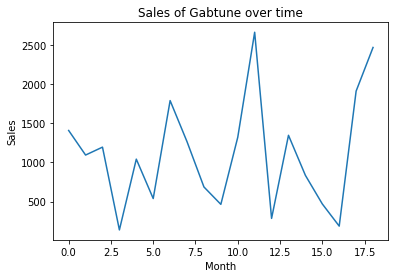

In [255]:
get_one_plot("Gabtune")

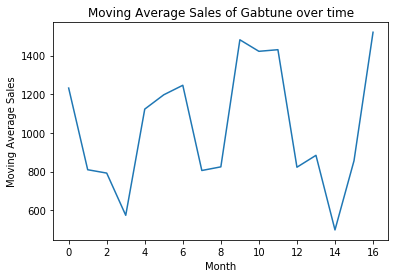

In [256]:
get_one_MA_plot("Gabtune")

get the gradient of fitted line on the moving average sales of a random company:

In [257]:
getGradient("Gabtune")

21.223491905263124

get the actual sales plots for all companies:

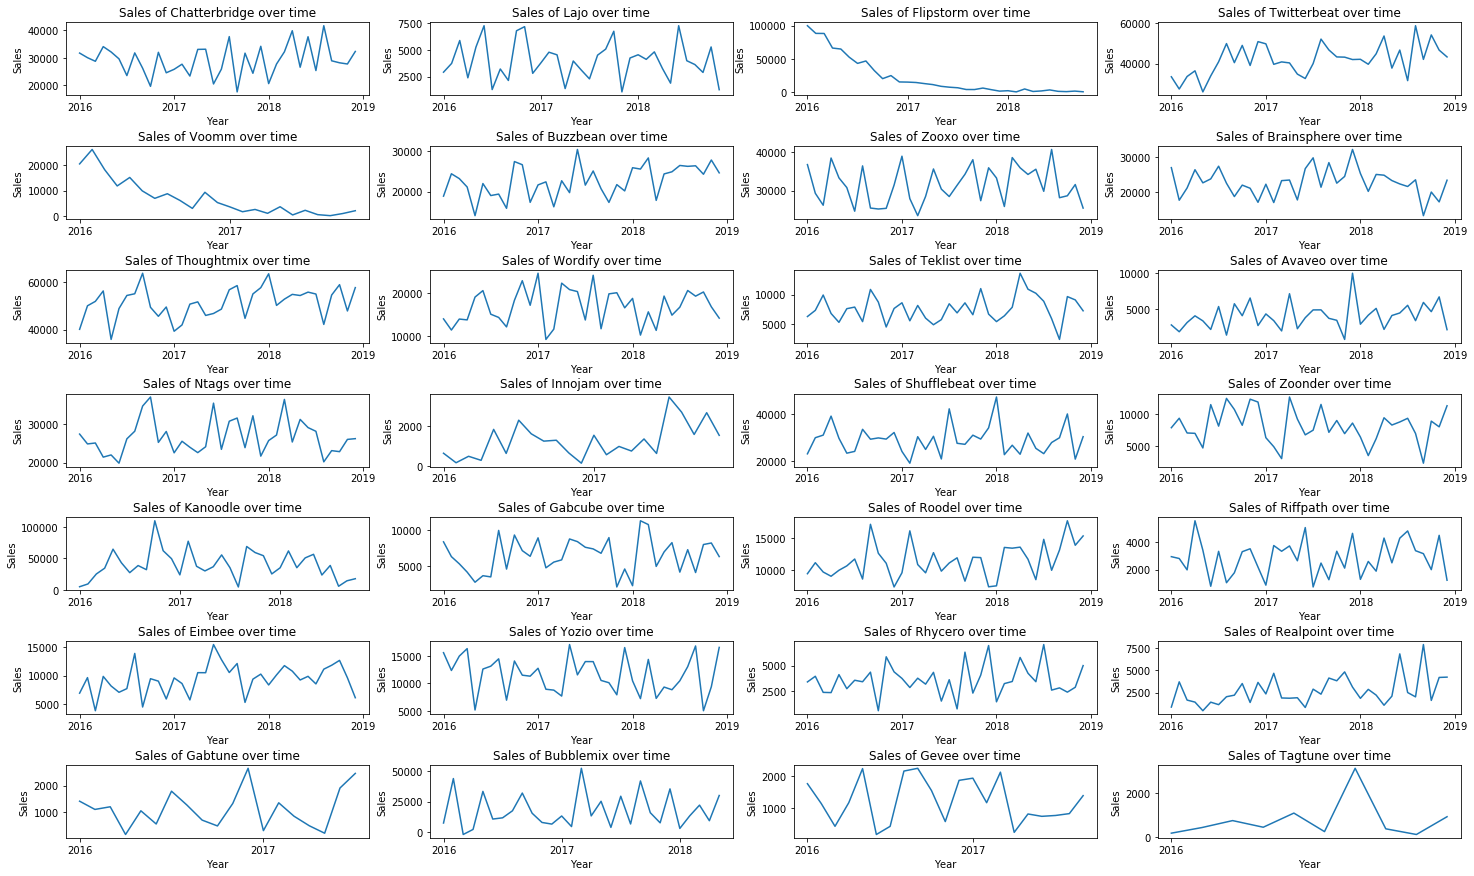

In [258]:
get_all_plots()

get the moving average sales plots for all companies:

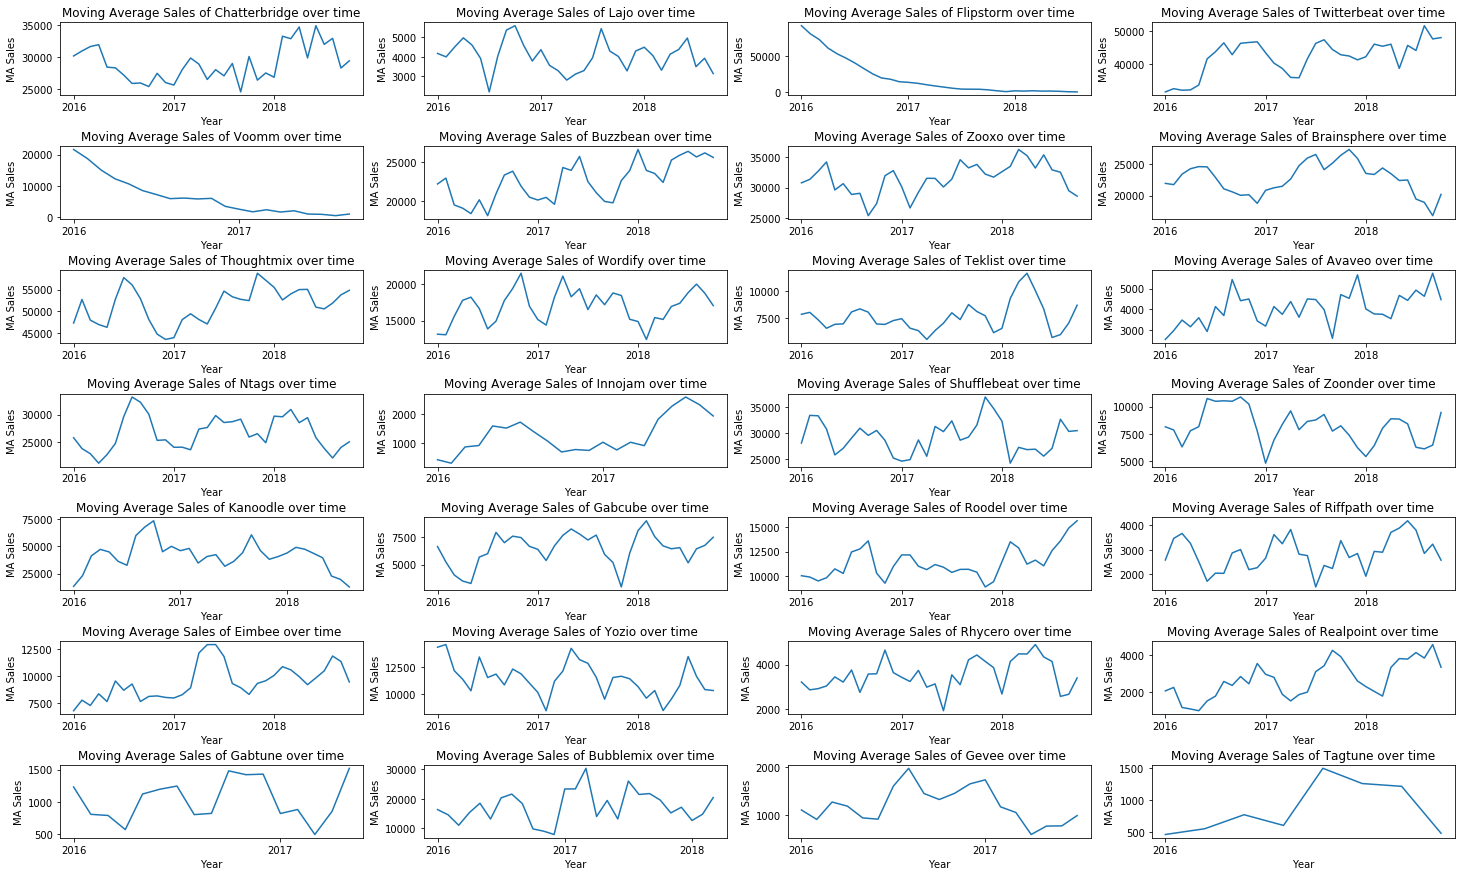

In [259]:
get_all_MA_plots()

get the gradients of the fitted line on moving average sales of all companies, and store this information in a pandas dataframe:

In [269]:
MA_gradients = get_all_gradients()

In [283]:
Declining = list(filter(lambda x : x[1] < -10, MA_gradients.items()))
Declining

[('Lajo', -13.060374587394968),
 ('Flipstorm', -2473.295320860658),
 ('Voomm', -910.597914936759),
 ('Brainsphere', -27.96259046023168),
 ('Zoonder', -34.19626512226513),
 ('Kanoodle', -163.94924532614112),
 ('Yozio', -54.12862009626761),
 ('Gevee', -14.992198005194792)]

In [279]:
tuple([x[0] for x in Declining])

('Flipstorm', 'Voomm', 'Kanoodle')

### Q3 Reasons Behind The Decline

In [284]:
c.execute('''
SELECT c.company, SUM(c.standardized_USD), c.year, gdp.country, gdp.value, population.value
FROM customer as c
LEFT JOIN gdp
On c.country = gdp.country AND c.year = gdp.year
LEFT JOIN population
ON c.country = population.country AND c.year= population.year
Where company in ('Flipstorm','Voomm','Kanoodle','Lajo')
GROUP BY company, c.year
''')

test=c.fetchall()
test

[('Flipstorm', 641350.7544590005, 2016, 'Greece', 195222000000.0, 10775971.0),
 ('Flipstorm', 91601.54159000004, 2017, 'Greece', 203086000000.0, 10754679.0),
 ('Flipstorm', 12361.454862, 2018, 'Greece', 218032000000.0, 10727668.0),
 ('Flipstorm', 1350.0662879999998, 2019, None, None, None),
 ('Kanoodle', 500526.7224075931, 2016, 'Japan', 4926670000000.0, 126994511.0),
 ('Kanoodle', 482435.26812154154, 2017, 'Japan', 4859950000000.0, 126785797.0),
 ('Kanoodle', 364321.6503773853, 2018, 'Japan', 4970920000000.0, 126529100.0),
 ('Lajo', 50737.16349899999, 2016, 'Greece', 195222000000.0, 10775971.0),
 ('Lajo', 41146.140186, 2017, 'Greece', 203086000000.0, 10754679.0),
 ('Lajo', 47082.81379600002, 2018, 'Greece', 218032000000.0, 10727668.0),
 ('Voomm', 141625.99449399996, 2016, 'France', 2471290000000.0, 66859768.0),
 ('Voomm', 17141.994736, 2017, 'France', 2586290000000.0, 66865144.0),
 ('Voomm', 2111.249652, 2018, 'France', 2777540000000.0, 66987244.0)]

In [146]:
# ## get ts list for plotting
# def creatTimeSeries(lst, year_index, month_index):
#     def helper(index):
#         date = datetime.datetime.strptime(
#             str(lst[index][year_index]) + "-" + str(lst[index][month_index]),
#             "%Y-%m")
#         return date
#     return [helper(x) for x in range(len(lst))]

## NEW QNS (choose 2-3 will do i think)
## 1 how many times do negative profit occur, order by time ( implemented, no graph) maybe we can have -ve counts / +ve counts !

## 2 how much money lost, order by sum of profit (to be implemented)
## 3. negative profit counts / positive profit counts --> ratio
## 4. negative profit / positive profit --> ratio, risk

### Negative Profit

In [246]:
c.execute('''
SELECT company, COUNT(*) as counts, SUM(standardized_USD)
FROM customer
Where standardized_USD < 0
GROUP BY company
ORDER BY counts Desc
''')

negative_by_counts=c.fetchall()
negative_by_counts

[('Thoughtmix', 10, -1285.259391),
 ('Twitterbeat', 8, -358.49294399999997),
 ('Chatterbridge', 7, -1027.06774),
 ('Zooxo', 7, -1569.4627911961882),
 ('Shufflebeat', 6, -596.333327),
 ('Flipstorm', 5, -485.44400199999995),
 ('Brainsphere', 4, -421.19359999999995),
 ('Buzzbean', 4, -392.832835),
 ('Ntags', 4, -685.483738),
 ('Wordify', 4, -300.32),
 ('Bubblemix', 2, -2414.2108849354595),
 ('Eimbee', 2, -144.28126699999999),
 ('Kanoodle', 2, -2728.7527963256402),
 ('Rhycero', 2, -241.96571),
 ('Yozio', 2, -348.71891000000005),
 ('Zoonder', 2, -129.62),
 ('Gabcube', 1, -57.922137000000006),
 ('Roodel', 1, -19.498392000000003)]

In [ ]:
## plot

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

In [205]:
df.columns

Index(['key', 'part', 'company', 'country', 'city', 'price', 'date',
       'currency_name', 'price_amount', 'currency_symbol',
       'exchange_rate_to_USD', 'standardized_USD', 'year', 'month'],
      dtype='object')

In [215]:
def betweenTime(Company,T_start,T_end):
    substitution=(Company,T_start,T_end)
    
    c.execute('''
    SELECT part, company, country, city, date, price, standardized_USD
    FROM customer 
    Where company = ? AND date Between ? AND ? 
    ''', substitution)
    
    return c.fetchall()

In [216]:
betweenTime('Chatterbridge','2016-01-02','2016-01-03')

[('54868-5165',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 00:01:05',
  '784.79€',
  854.4008729999999),
 ('44946-1046',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 04:51:55',
  '412.55€',
  449.143185),
 ('16729-167',
  'Chatterbridge',
  'Spain',
  'Barcelona',
  '2016-01-02 07:20:59',
  '359.52€',
  391.409424)]

In [221]:
def latest(x):
    substitution=(x,)
    
    c.execute('''
    SELECT part, company, country, city, date, price, standardized_USD
    FROM customer 
    Order BY date DESC
    LIMIT ?
    ''', substitution)
    
    return c.fetchall()

In [222]:
latest(5)

[('43419-018',
  'Flipstorm',
  'Greece',
  'Athens',
  '2019-05-14 22:48:39',
  '139.56€',
  156.67005600000002),
 ('49288-0285',
  'Flipstorm',
  'Greece',
  'Athens',
  '2019-02-21 20:05:00',
  '1051.08€',
  1193.3962319999998),
 ('52343-025',
  'Brainsphere',
  'Portugal',
  'Braga',
  '2018-12-31 21:38:02',
  '686.1€',
  785.5845),
 ('49999-737',
  'Thoughtmix',
  'Portugal',
  'Amadora',
  '2018-12-31 21:24:17',
  '828.37€',
  948.48365),
 ('21695-267',
  'Roodel',
  'Portugal',
  'Aranhas',
  '2018-12-31 20:48:14',
  '606.37€',
  694.2936500000001)]

In [273]:
def salePerCompanyPerDay():
    
    c.execute('''
    SELECT company, DATE(date) , SUM(standardized_USD)
    FROM customer 
    Group BY company, Date(date)
    ''')
    
    return c.fetchall()

In [274]:
salePerCompanyPerDay()

[('Avaveo', '2016-01-03', 1121.2739040000001),
 ('Avaveo', '2016-01-06', 738.652146),
 ('Avaveo', '2016-01-18', 390.43463199999997),
 ('Avaveo', '2016-01-19', 515.52358),
 ('Avaveo', '2016-02-01', 150.645444),
 ('Avaveo', '2016-02-11', 831.723753),
 ('Avaveo', '2016-02-20', 833.165352),
 ('Avaveo', '2016-03-07', 420.387093),
 ('Avaveo', '2016-03-08', 969.0193320000001),
 ('Avaveo', '2016-03-18', 563.1604699999999),
 ('Avaveo', '2016-03-20', 185.336528),
 ('Avaveo', '2016-03-22', 965.330776),
 ('Avaveo', '2016-04-02', 410.831784),
 ('Avaveo', '2016-04-12', 530.210296),
 ('Avaveo', '2016-04-13', 1854.3746339999998),
 ('Avaveo', '2016-04-14', 519.22354),
 ('Avaveo', '2016-04-18', 723.75359),
 ('Avaveo', '2016-05-10', 117.333125),
 ('Avaveo', '2016-05-12', 1147.134247),
 ('Avaveo', '2016-05-13', 525.616664),
 ('Avaveo', '2016-05-20', 1357.3307149999998),
 ('Avaveo', '2016-05-27', 187.410208),
 ('Avaveo', '2016-06-11', 1171.015272),
 ('Avaveo', '2016-06-16', 964.271504),
 ('Avaveo', '2016-0

---